In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import numpy as np


In [2]:
hdf = pd.HDFStore("S6.filtered_matrix.h5",mode='r' )

In [18]:
!pip install tables

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 26.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.2/375.2 kB 6.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:

def write_dense_matrix_in_chunks(h5_file_path, csv_file_path, chunk_size=100):
    with h5py.File(h5_file_path, 'r') as file:
        indices = file['matrix/indices'][:]
        indptr = file['matrix/indptr'][:]
        data = file['matrix/data'][:]
        shape = file['matrix/shape'][:]
        feature_names = file['matrix/features/name'][:].astype(str)
        barcodes = file['matrix/barcodes'][:].astype(str)
    total_columns = shape[1]
    num_chunks = total_columns // chunk_size + (1 if total_columns % chunk_size else 0)
    for chunk_idx in range(num_chunks):
        start_col = chunk_idx * chunk_size
        end_col = min((chunk_idx + 1) * chunk_size, total_columns)

        chunk_dense_matrix = np.zeros((shape[0], end_col - start_col), dtype=np.float32)

        for i in range(start_col, end_col):
            col_start_idx, col_end_idx = indptr[i], indptr[i + 1]
            chunk_dense_matrix[indices[col_start_idx:col_end_idx], i - start_col] = data[col_start_idx:col_end_idx]

        df_chunk = pd.DataFrame(chunk_dense_matrix, index=feature_names, columns=barcodes[start_col:end_col])

        write_header = True if chunk_idx == 0 else False
        df_chunk.to_csv(csv_file_path, mode='a', header=write_header)


h5_file_path = 'S6.filtered_matrix.h5'
csv_file_path = 'dense_matrix.csv'
write_dense_matrix_in_chunks(h5_file_path, csv_file_path, chunk_size=100)


In [9]:

file_paths = [
    'tables/basal.csv',
    'tables/ciliated.csv',
    'tables/ciliated1.csv',
    'tables/ciliated2.csv',
    'tables/MBP.csv',
    'tables/mucous.csv',
    'tables/SBP.csv',
    'tables/secretory.csv',
    'tables/serous1.csv',
    'tables/serous2.csv',
    'tables/AB.csv',
    'tables/BP.csv',
    'tables/club.csv',
    'tables/globlet.csv'
]

merged_df = pd.DataFrame()

for file_path in file_paths:
    current_df = pd.read_csv(file_path, sep=";")
    current_df = current_df.drop_duplicates(subset='gene', keep='first')
    table_name = file_path.split('/')[-1].split('.')[0] 
    current_df.rename(columns={'p-val': f'p-val_{table_name}'}, inplace=True)

    if merged_df.empty:
        merged_df = current_df
    else:
        merged_df = pd.merge(merged_df, current_df, on='gene', how='outer')
merged_df.fillna(0, inplace=True)

merged_df.to_csv('tables/merged_table.csv', index=False)
df = df[df['gene_id'].notna()]
print(merged_df.head())



     gene    p_val_x  Unnamed: 2_x  Unnamed: 3_x  Unnamed: 4_x  Unnamed: 5_x  \
0     FOS  1,39E-231           0.0           0.0           0.0           0.0   
1     JUN  5,93E-242           0.0           0.0           0.0           0.0   
2   ZFP36  1,16E-160           0.0           0.0           0.0           0.0   
3  TUBA1B  9,98E-188           0.0           0.0           0.0           0.0   
4    JUNB  3,29E-190           0.0           0.0           0.0           0.0   

   Unnamed: 6_x  Unnamed: 7_x   p_val_y  Unnamed: 2_y  ...  Unnamed: 5_x  \
0           0.0           0.0         0           0.0  ...           0.0   
1           0.0           0.0  3,43E-47           0.0  ...           0.0   
2           0.0           0.0  2,23E-28           0.0  ...           0.0   
3           0.0           0.0         0           0.0  ...           0.0   
4           0.0           0.0  6,50E-35           0.0  ...           0.0   

   Unnamed: 6_x  Unnamed: 7_x   p_val_y  Unnamed: 2_y Unnamed:

/tmp/ipykernel_2298207/3249027578.py:38: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 4_x', 'Unnamed: 3_x', 'Unnamed: 5_x', 'p_val_x', 'Unnamed: 6_x', 'Unnamed: 7_x', 'Unnamed: 2_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = pd.merge(merged_df, current_df, on='gene', how='outer')
/tmp/ipykernel_2298207/3249027578.py:38: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 4_x', 'Unnamed: 3_x', 'Unnamed: 5_x', 'p_val_x', 'Unnamed: 6_x', 'Unnamed: 2_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = pd.merge(merged_df, current_df, on='gene', how='outer')
/tmp/ipykernel_2298207/3249027578.py:38: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 4_x', 'Unnamed: 3_x', 'p_val_x', 'Unnamed: 5_x', 'Unnamed: 6_x', 'Unnamed: 7_x', 'Unnamed: 2_x'} in the result is deprecated and will raise a MergeError in a future version.
  merg

In [10]:
merged_df=pd.read_csv('signature_nosal.csv', sep=";")
df = df[df['gene_id'].notna()]
merged_df.to_csv('merged_table.csv', index=False)

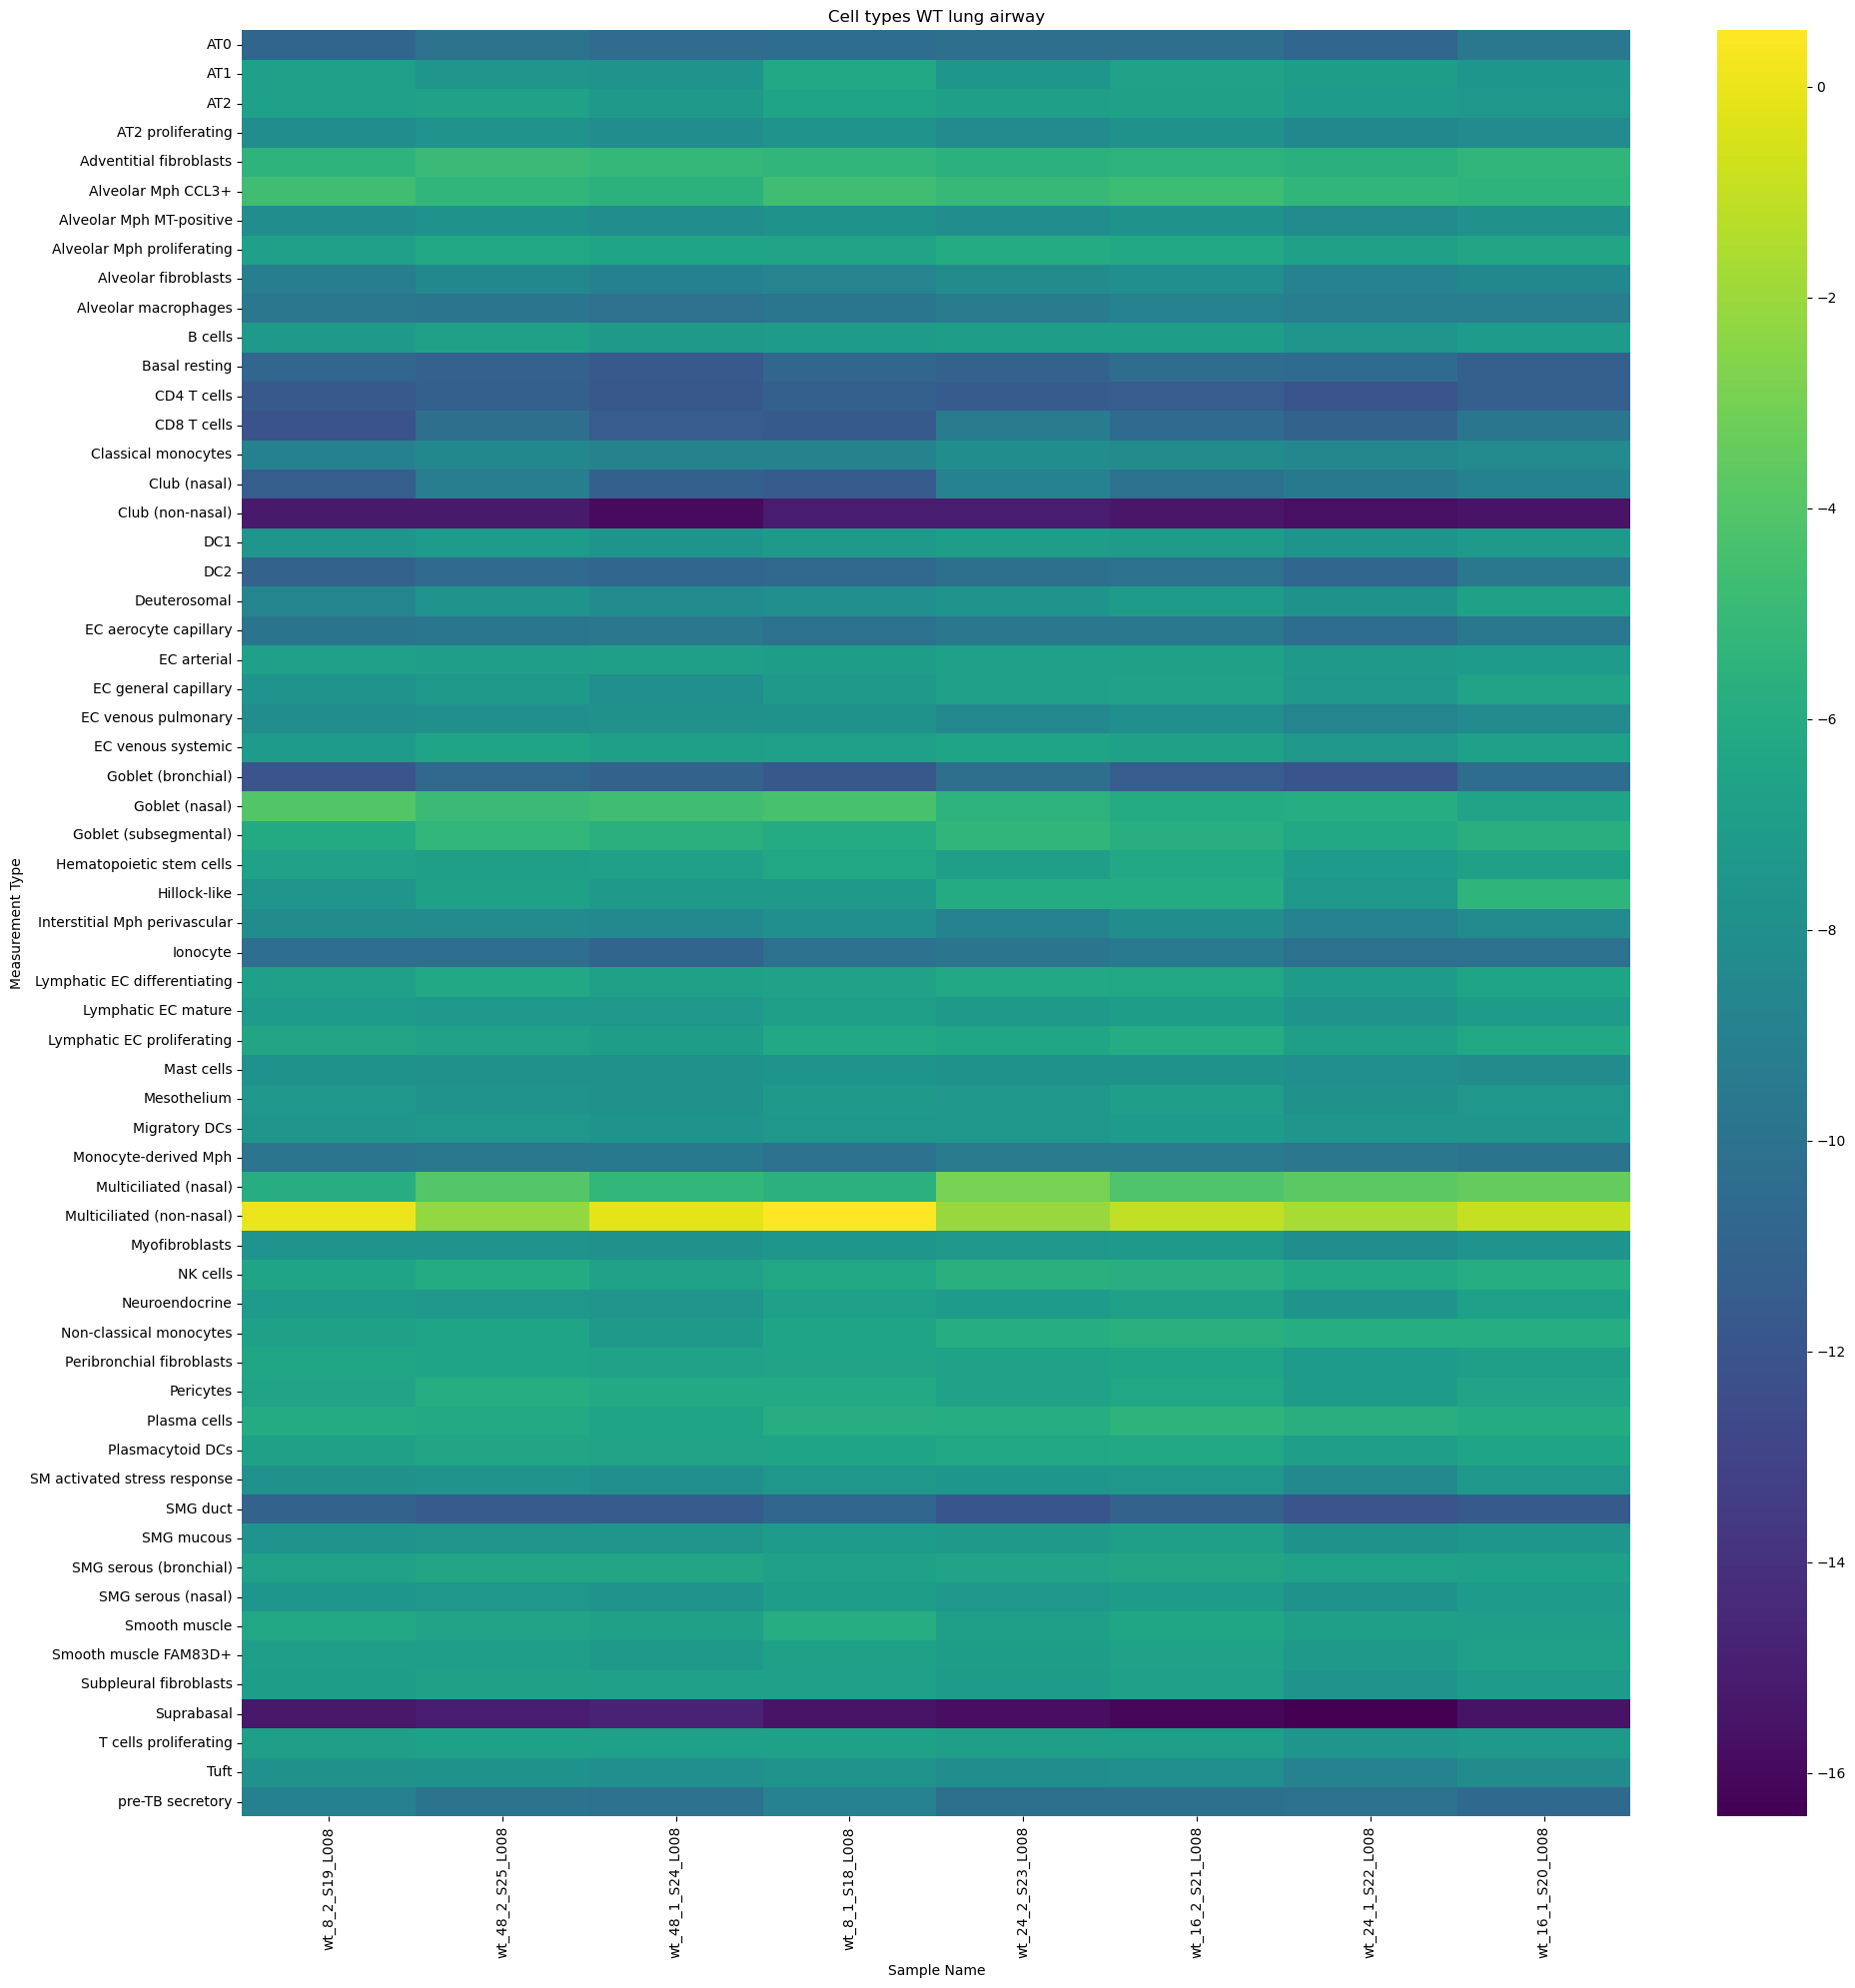

In [6]:

file_path = 'decision_matrix_wt_lung_atlas.csv'
data = pd.read_csv(file_path)
plt.figure(figsize=(20, 20))
heatmap_data = data.drop(columns=data.columns[0])
sns.heatmap(heatmap_data.transpose(), cmap="viridis", xticklabels=data[data.columns[0]])
plt.xticks(rotation=90)
plt.title('Cell types WT lung airway')
plt.ylabel('Measurement Type')
plt.xlabel('Sample Name')
plt.tight_layout()  # Adjust layout to not cut off labels
save_path = 'figs/WTlungatlas.png'
plt.savefig(save_path)

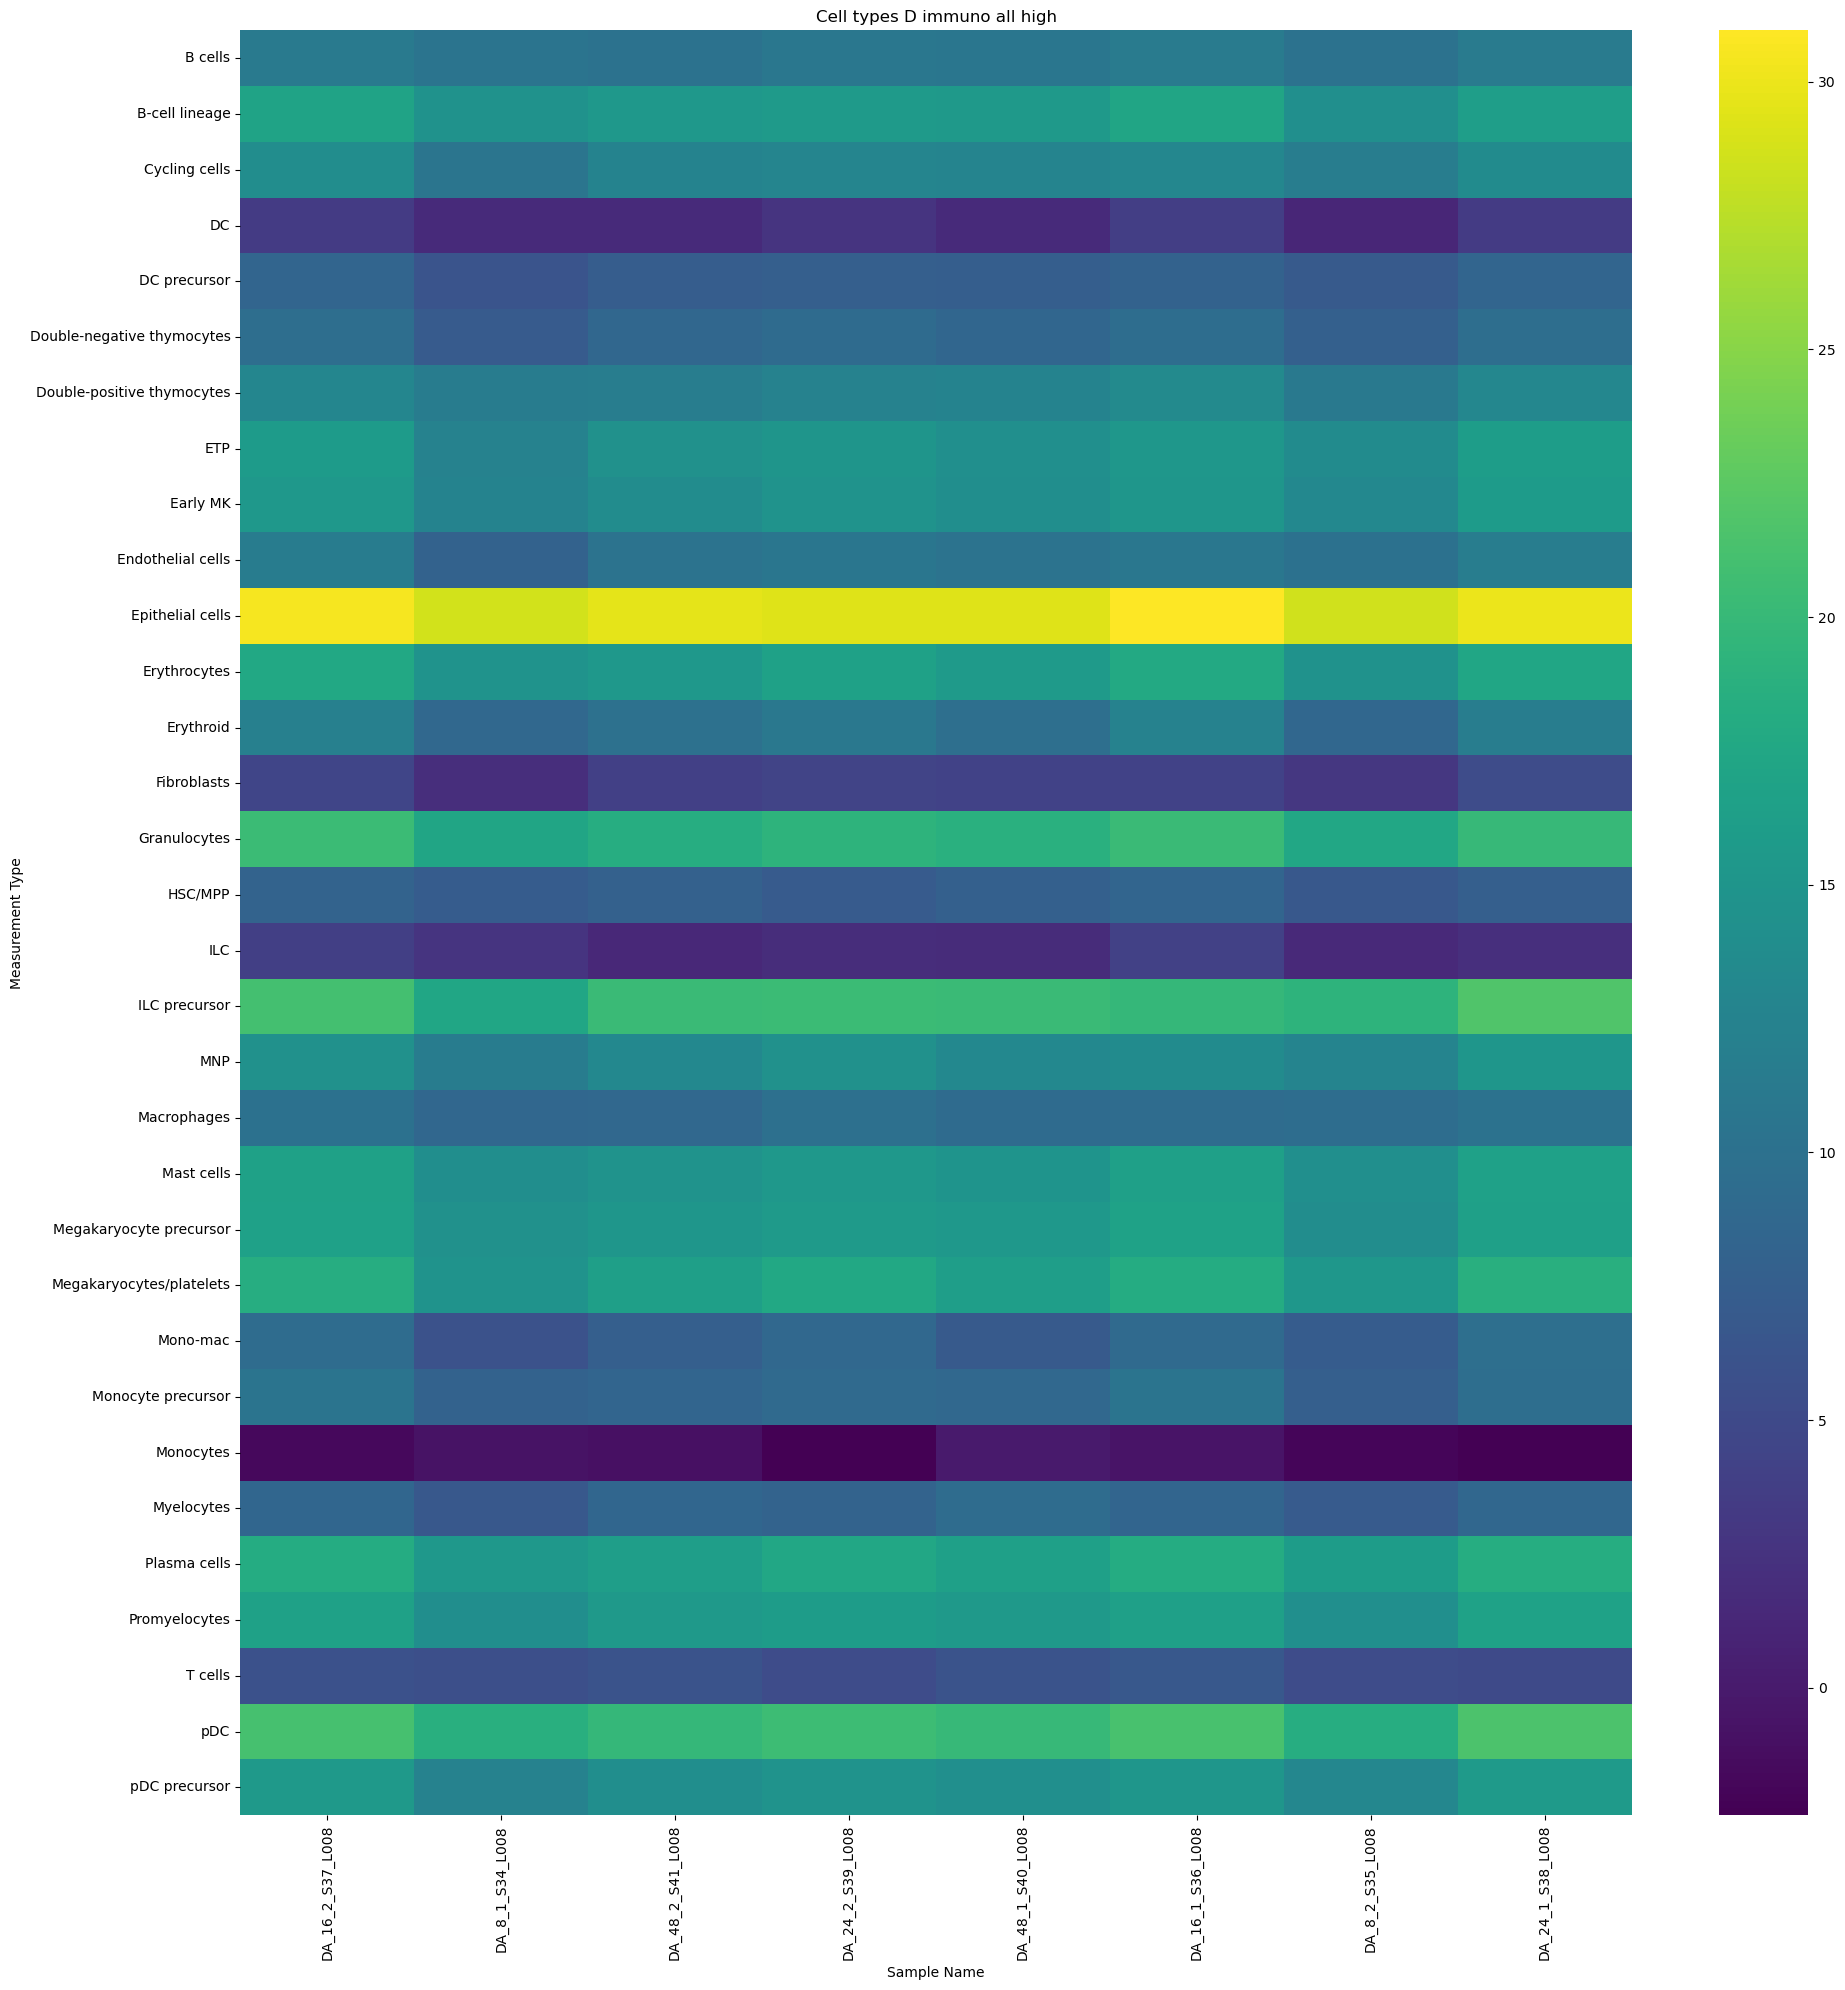

In [38]:
file_path = 'decision_matrix_high.csv'

In [18]:
data

,Unnamed: 0,Age-associated B cells,Alveolar macrophages,B cells,CD16+ NK cells,CD16- NK cells,CD8a/a,CD8a/b(entry),CMP,CRTAM+ gamma-delta T cells,...,Transitional B cells,Transitional DC,Transitional NK,Treg(diff),Trm cytotoxic T cells,Type 1 helper T cells,Type 17 helper T cells,gamma-delta T cells,pDC,pDC precursor
0,DA_16_2_S37_L008,0.999999,0.999503,0.999703,0.978739,0.999976,0.999995,1.000000,1.0,0.999995,...,1.0,1.000000,1.0,0.999959,1.000000,0.999986,0.999967,1.0,1.0,1.000000
1,DA_8_1_S34_L008,0.999998,0.998509,0.999342,0.969540,0.999944,0.999936,0.999995,1.0,0.999944,...,1.0,0.999999,1.0,0.999750,0.999996,0.999915,0.999749,1.0,1.0,0.999998
2,DA_48_2_S41_L008,0.999999,0.997142,0.999545,0.942960,0.999884,0.999990,0.999999,1.0,0.999990,...,1.0,1.000000,1.0,0.999929,0.999999,0.999966,0.999392,1.0,1.0,1.000000
3,DA_24_2_S39_L008,0.999999,0.998345,0.999497,0.935741,0.999896,0.999991,0.999999,1.0,0.999993,...,1.0,1.000000,1.0,0.999883,0.999999,0.999967,0.999833,1.0,1.0,1.000000
4,DA_48_1_S40_L008,0.999999,0.998942,0.999790,0.974306,0.999912,0.999987,0.999999,1.0,0.999983,...,1.0,1.000000,1.0,0.999927,0.999999,0.999969,0.999253,1.0,1.0,1.000000
5,DA_16_1_S36_L008,0.999999,0.999779,0.999651,0.991597,0.999993,0.999996,1.000000,1.0,0.999994,...,1.0,1.000000,1.0,0.999981,0.999999,0.999988,0.999987,1.0,1.0,1.000000
6,DA_8_2_S35_L008,0.999998,0.997353,0.999555,0.911625,0.999736,0.999958,0.999999,1.0,0.999979,...,1.0,0.999999,1.0,0.999590,0.999998,0.999923,0.999546,1.0,1.0,1.000000
7,DA_24_1_S38_L008,0.999999,0.999009,0.999666,0.960583,0.999937,0.999997,1.000000,1.0,0.999998,...,1.0,1.000000,1.0,0.999923,1.000000,0.999985,0.999923,1.0,1.0,1.000000
